In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial
from src.dataset import Dataset
import torch.utils.data
import torch


In [2]:
file_name_zueri = r'D:\Temp\AgroLuege\raw_data\ZueriCrop\ZueriCrop.hdf5'

file_name_zueri = r'C:\Temp\AgroLuege\raw_data\ZueriCrop\ZueriCrop.hdf5'
traindataset= Dataset(file_name_zueri, 0., 'train', False, 1, "labels.csv",
                      num_channel=4,time_downsample_factor=2,
                      apply_cloud_masking=False)

testdataset= Dataset(file_name_zueri, 0., 'test', True, 1, "labels.csv",
                      num_channel=4,time_downsample_factor=2,
                      apply_cloud_masking=False)

5fold:  1   Mode:  train
Dataset size:  27977
Valid dataset size:  22382
Sequence length:  142
Spatial size:  (24, 24)
Number of classes:  52
Number of classes - local-1:  6
Number of classes - local-2:  20
5fold:  1   Mode:  test
Dataset size:  27977
Valid dataset size:  5595
Sequence length:  142
Spatial size:  (24, 24)
Number of classes:  52
Number of classes - local-1:  6
Number of classes - local-2:  20


In [3]:
traindataloader = torch.utils.data.DataLoader(traindataset, batch_size=100, shuffle=True, num_workers=0)
testdataloader = torch.utils.data.DataLoader(testdataset, batch_size=100, shuffle=True, num_workers=0)
# Initialize an empty list to store batches
all_data_input = []
all_data_target = []

# Iterate through the DataLoader
for batch in traindataloader:
    input, target, target_2, target_3 = batch

    all_data_input.append(input)
    all_data_target.append(target_2)

# Concatenate all batches into a single tensor along the batch dimension (dim=0)
input_train = torch.cat(all_data_input, dim=0)
target_train = torch.cat(all_data_target, dim=0)


In [5]:
sigma_min = 1
sigma_max = 16
input_train= input_train[0:22000]
target_train = target_train[0:22000]
reshaped_tensor_train = input_train.reshape(24*220, 24*100, 4)
reshaped_target_train = target_train.reshape(24*220, 24*100)

features_func_train = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        channel_axis=-1)
train_features = features_func_train(reshaped_tensor_train)


In [63]:
target_train.shape

torch.Size([22000, 24, 24])

In [69]:
import torch

# Convert the tensor to a NumPy array to use NumPy functions
input_array = target_train.numpy()

# Find empty rows (rows with all elements being zero or close to zero)
empty_rows = np.where(~input_array.any(axis=(1, 2)))[0]
# Print the indices of empty rows
print("Indices of empty rows:", len(empty_rows))

zeros_per_row = (target_train == 0).sum(dim=(1, 2))

# Print the count of zeros per row
print("Count of zeros per row:", zeros_per_row)


Indices of empty rows: 64
Count of zeros per row: tensor([489, 424,  76,  ..., 400,  98, 133])


In [78]:
len(zeros_per_row[zeros_per_row > 432])

5777

In [16]:
# Initialize an empty list to store batches
all_data_input = []
all_data_target = []

# Iterate through the DataLoader
for batch in testdataloader:
    input, target, target_2, target_3,field_instance = batch

    all_data_input.append(input)
    all_data_target.append(target_2)

# Concatenate all batches into a single tensor along the batch dimension (dim=0)
input_test = torch.cat(all_data_input, dim=0)
target_test = torch.cat(all_data_target, dim=0)
    
input_test= input_test[0:5000]
target_test = target_test[0:5000]

reshaped_tensor_test = input_test.reshape(24*50, 24*100, 4)
reshaped_target_test = target_test.reshape(24*50, 24*100)

features_func_test = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        channel_axis=-1)
test_features = features_func_test(reshaped_tensor_test)


In [79]:
class_weights = {0: 1e-40, 1: 1, 2:1,3:1,4:1,5:1}
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1,
                             max_depth=10, max_samples=0.05,
                             class_weight=class_weights)

clf = future.fit_segmenter(reshaped_target_train, train_features, clf)
result = future.predict_segmenter(train_features, clf)

In [86]:
result = future.predict_segmenter(train_features, clf)

In [87]:
unique, counts = np.unique(result, return_counts=True)
print(np.asarray((unique, counts)).T)

[[       1   692786]
 [       3 11979214]]


In [88]:
np.sum(result == reshaped_target_train.numpy())/len(reshaped_target_train.flatten())*100

30.841043244949496

In [89]:
result = future.predict_segmenter(test_features, clf)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


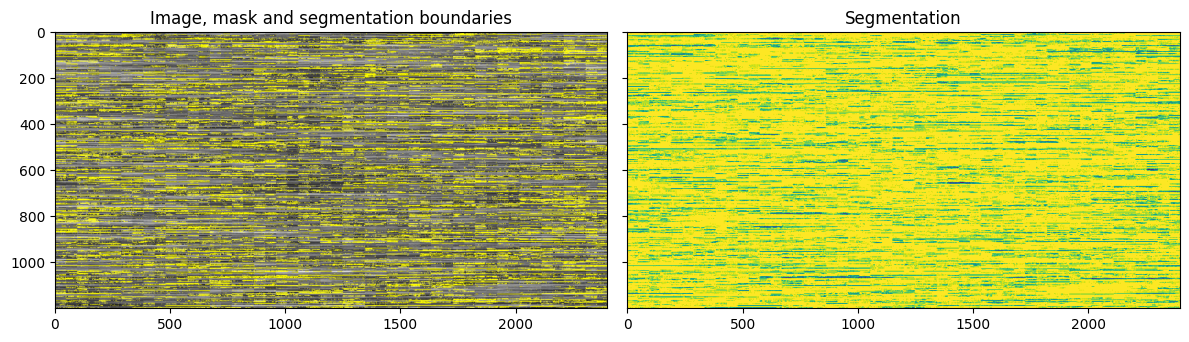

In [91]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))
ax[0].imshow(segmentation.mark_boundaries(reshaped_tensor_test[:,:,1:4].numpy(), result, mode='thick'))
# ax[0].contour(reshaped_target.numpy())
ax[0].set_title('Image, mask and segmentation boundaries')
ax[1].imshow(result)
ax[1].set_title('Segmentation')
fig.tight_layout()

In [92]:
unique, counts = np.unique(result, return_counts=True)
print(np.asarray((unique, counts)).T)

[[      1  231673]
 [      3 2648327]]


In [93]:
np.sum(result == reshaped_target_test.numpy())/len(reshaped_target_test.flatten())*100

21.098854166666666